In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from performance_measures import c_index, brier_score, weighted_c_index, weighted_brier_score,log_partial_lik
from neural_models import negLogLikelihood, linearCoxPH_Regression, MLP, negLogLikelihood_per_sample
from fairness_measures import individual_fairness, group_fairness, intersect_fairness, individual_fairness_scale, CI, C_index_difference
from utilities import prepare_data3

from sksurv.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import brier_score_loss
from sksurv.metrics import concordance_index_censored, brier_score, integrated_brier_score
from sksurv.metrics import concordance_index_ipcw,cumulative_dynamic_auc
from sklearn.linear_model import QuantileRegressor
from sksurv.util import Surv
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from scipy import optimize
from compute_survival_function import predict_survival_function  

# Simulation
from cox_dgp_simulation import simulate_cox_dgp, simulate_weibull_failure_cox
from numpy.random import normal, uniform, exponential, binomial, beta, weibull
from scipy.stats import norm

#The function below ensures that we seed all random generators with the same value to get reproducible results
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

def threshplus(x):
    y = x.copy()
    y[y<0]=0
    return y

def threshplus_tensor(x):
    y = x.clone()
    y[y<0]=0
    return y

def loss_map_chi_factory(loss_values, eps):
    # return lambda x: np.sqrt(2)*(1.0/eps-1.0)*np.sqrt(np.mean(threshplus(loss_values-x)**2.0)) + x
    return lambda x: np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1) * np.sqrt(np.mean(threshplus(loss_values - x) ** 2.0)) + x

def loss_map_chi_factory_tensor(loss_values, eps, opt_eta):
    # return np.sqrt(2)*(1.0/eps-1.0)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta
    return np.sqrt(2 * ((1.0 / eps - 1.0)** 2.0)+1)*torch.sqrt(torch.mean(threshplus_tensor(loss_values-opt_eta)**2.0)) + opt_eta

In [2]:
def fit_dro_cox(X, event, time, eps=0.1, lr=0.01, epochs=500):
    """Fit DRO-Cox model, return a nn.module instance"""
    X, event, time = prepare_data3(X, event, time) # sort the data by time for fitting cox model
    X = Variable((torch.from_numpy(X)).float())
    event = Variable((torch.from_numpy(event)).float())
    time = Variable((torch.from_numpy(time)).float())

    criterion_per_sample = negLogLikelihood_per_sample()
    model = linearCoxPH_Regression(X.shape[1],1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        # Original loss
        outputs = model(X)
        per_sample_losses = criterion_per_sample(outputs, event)
        print(per_sample_losses)
        # Update eta with beta fixed
        chi_loss_np = loss_map_chi_factory(per_sample_losses.detach().numpy(), eps)
        cutpt = optimize.fminbound(chi_loss_np, np.min(per_sample_losses.detach().numpy()) - 1000.0, np.max(per_sample_losses.detach().numpy()))

        # Update beta with eta fixed
        loss = loss_map_chi_factory_tensor(per_sample_losses, eps, cutpt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(cutpt)
        # print(loss)
    return model, cutpt

In [ ]:
# class weibull_baseline_negLogLikelihood_per_sample(nn.Module):
#     def __init__(self):
#         super(weibull_baseline_negLogLikelihood_per_sample, self).__init__()

#     def forward(self, prediction, time, event):
#         log_hr = prediction.transpose(0, 1)
#         censored_likelihood = -event.float() * log_hr + time*torch.exp(log_hr)
#         return censored_likelihood

# def fit_weibull_baseline_dro_cox(X, event, time, eps=0.1, lr=0.01, epochs=500):
#     """Fit DRO-Cox model, return a nn.module instance"""
#     X, event, time = prepare_data3(X, event, time) # sort the data by time for fitting cox model
#     X = Variable((torch.from_numpy(X)).float())
#     event = Variable((torch.from_numpy(event)).float())
#     time = Variable((torch.from_numpy(time)).float())

#     criterion_per_sample = weibull_baseline_negLogLikelihood_per_sample()
#     model = linearCoxPH_Regression(X.shape[1],1)
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     for epoch in range(epochs):
#         # Original loss
#         outputs = model(X)
#         per_sample_losses = criterion_per_sample(outputs, time, event)
#         # Update eta with beta fixed
#         chi_loss_np = loss_map_chi_factory(per_sample_losses.detach().numpy(), eps)
#         cutpt = optimize.fminbound(chi_loss_np, np.min(per_sample_losses.detach().numpy()) - 1000.0, np.max(per_sample_losses.detach().numpy()))

#         # Update beta with eta fixed
#         loss = loss_map_chi_factory_tensor(per_sample_losses, eps, cutpt)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         #print(loss)
#     return model, cutpt

In [ ]:
def eval_test(beta_fitted, beta_dgp, X_test):
    """Directly comparate the fitted beta to the true beta"""
    return np.dot(X_test, beta_dgp-beta_fitted)**2

## Scipy version

In [15]:
class DroOptimizer:
    def __init__(self, loss_func, eps):
        self.loss_func = loss_func
        self.eps = eps
        self.beta = None
        self.eta = None

    def dro_loss(self, beta, eta, X, y, is_beta0_intercept=False, verbose=False, **kwargs):
        if is_beta0_intercept:
            pred = beta[0] + np.dot(X, beta[1:])
        else:
            pred = np.dot(X, beta)
        out = np.sqrt(2 * ((1.0 / self.eps - 1.0)** 2.0)+1) * np.sqrt(np.mean(threshplus(self.loss_func(pred, y, **kwargs) - eta) ** 2.0)) + eta
        if verbose:
            print(f"beta = {beta}, eta = {eta}, dro loss = {out}")
        return out

    def fit_dro(self, X, y, is_include_intercept=False, verbose=False, **kwargs):
        func = lambda para: self.dro_loss(para[:-1], para[-1], X, y, verbose, **kwargs)
        para_len = X.shape[1] + 1
        para_len += 1 if is_include_intercept else 0
        para_init = normal(size=para_len)
        self.optimizer = optimize.minimize(fun=func, x0=para_init)
        para_fitted = self.optimizer.x
        self.beta = para_fitted[:-1]
        self.eta = para_fitted[-1]

    def predict(self, X):
        out = np.dot(X, self.beta)
        return out

In [ ]:
set_random_seed(1)
sim_n_train = 1000
censor_rate = 0.4
beta = np.array([0.5, -0.1])
std_exp_baseline_loss = lambda pred, event, time: -event * pred + time*np.exp(pred)

sim_X_train = normal(size=(sim_n_train, len(beta)))
log_hr = np.dot(sim_X_train, beta)
sim_failure_time, sim_censor_time, sim_event, sim_time = simulate_weibull_failure_cox(log_hr, S0_shape=1.0, censor_rate = censor_rate)
sim_event = np.float64(sim_event)

eps_candidates = np.linspace(0.1, 0.9, 9)
beta_fitted = np.zeros((len(eps_candidates), len(beta), 2))
eta_fitted = np.zeros((len(eps_candidates), 2))
dro_loss_fitted = np.zeros((len(eps_candidates), 2))
for eps_ind, eps in enumerate(eps_candidates):
    model_torch, eta_fitted[eps_ind, 0] = fit_std_exp_baseline_dro_cox(sim_X_train, sim_event, sim_time, eps=eps, lr=0.01, epochs=500)
    model_scipy = DroOptimizer(std_exp_baseline_loss, eps = eps)
    model_scipy.fit_dro(sim_X_train, sim_event, sim_time, verbose=False)
    beta_fitted[eps_ind,:,0] = next(model_torch.parameters()).detach().numpy().reshape((-1,))
    beta_fitted[eps_ind,:,1] = model_scipy.beta
    eta_fitted[eps_ind,1] = model_scipy.eta
    dro_loss_fitted[eps_ind,0] = model_scipy.dro_loss(beta_fitted[eps_ind,:,0], eta_fitted[eps_ind,0], sim_X_train, sim_event, sim_time)
    dro_loss_fitted[eps_ind,1] = model_scipy.dro_loss(beta_fitted[eps_ind,:,1], eta_fitted[eps_ind,1], sim_X_train, sim_event, sim_time)
    print(eps)

NameError: name 'fit_std_exp_baseline_dro_cox' is not defined

In [192]:
model_scipy = DroOptimizer(std_exp_baseline_loss, eps = 0.3)

In [194]:
model_scipy.dro_loss(beta_fitted[2,:,1], eta_fitted[2,1], sim_X_train, sim_event, sim_time)

2.3160994377291204

In [190]:
beta_fitted[2,:,:]

array([[ 0.52994472,  0.60719668],
       [-0.03346535, -0.01245701]])

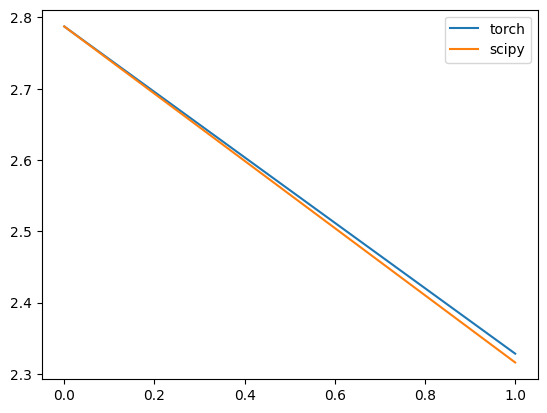

In [196]:
plt.plot(dro_loss_fitted[1:3,0], label = "torch")
plt.plot(dro_loss_fitted[1:3,1], label = "scipy")
plt.legend()

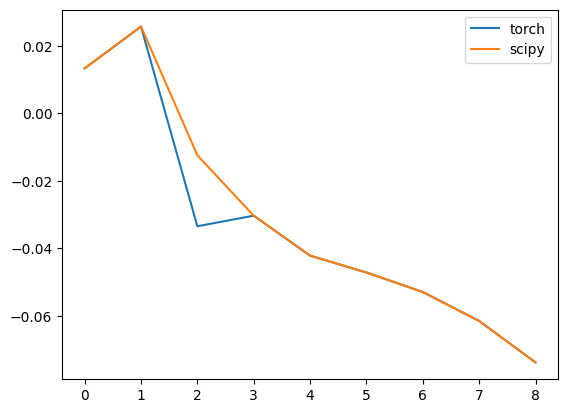

In [186]:
plt.plot(beta_fitted[:,1,0], label = "torch")
plt.plot(beta_fitted[:,1,1], label = "scipy")
plt.legend()

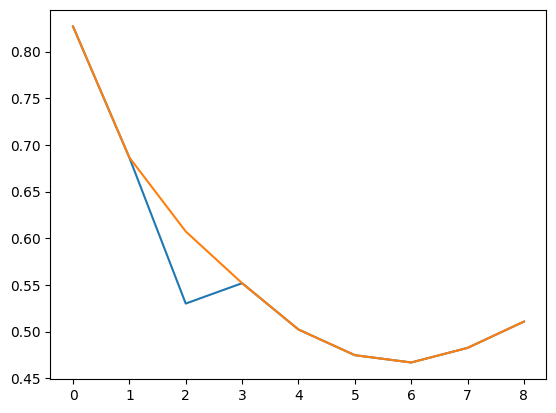

In [187]:
plt.plot(beta_fitted[:,0,0])
plt.plot(beta_fitted[:,0,1])

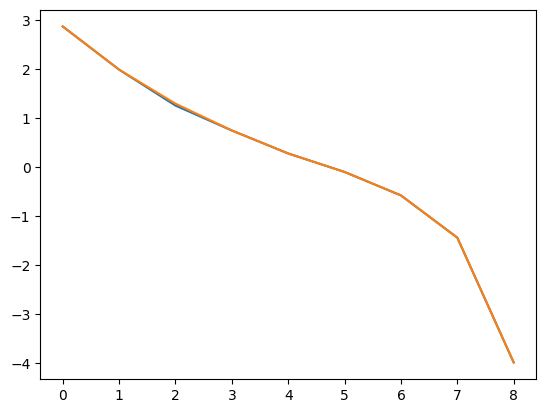

In [188]:
plt.plot(eta_fitted[:,0])
plt.plot(eta_fitted[:,1])

In [112]:
set_random_seed(10)
std_exp_baseline_loss = lambda pred, event, time: -event * pred + time*np.exp(pred)

model = DroOptimizer(std_exp_baseline_loss, eps = 0.7)
model.fit_dro(sim_X_train, sim_event, sim_time, verbose=True)

beta: [ 1.35321907 -0.29410274], eta: -1.5733393151115878
beta: [ 0.93343098 -0.33759261], eta: -1.528917151708472
beta: [ 0.93503837 -0.35024011], eta: -1.47365724854103
beta: [ 0.93365964 -0.37665098], eta: -1.3521017948973584
beta: [ 0.93379356 -0.43725252], eta: -1.0512677638957892
beta: [ 0.93610761 -0.42877649], eta: -1.0789957945864608
beta: [ 0.93589307 -0.42522442], eta: -1.0788098861554931
beta: [ 0.93589119 -0.41961624], eta: -1.0691096575475787
beta: [ 0.93571499 -0.41339347], eta: -1.0501549005998534
beta: [ 0.93575576 -0.4137438 ], eta: -1.0485161689286175
beta: [ 0.93574154 -0.41390362], eta: -1.0480556974625412


In [ ]:
fun = lambda para: print(f"beta: {para[:-1]}, eta: {para[-1]}")
fun(123)

123


In [85]:
import scipy
scipy.__version__

'1.9.0'

In [72]:
model.optimizer

      fun: 2.705596674201504
 hess_inv: array([[ 0.19733129,  0.00829592,  0.07914015],
       [ 0.00829592,  0.22900889, -0.01862578],
       [ 0.07914015, -0.01862578,  2.54504475]])
      jac: array([-5.81145287e-06,  2.05636024e-06,  1.96695328e-06])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 17
     njev: 20
   status: 0
  success: True
        x: array([ 0.95898799, -0.49639942,  0.63540865])

In [52]:
model.beta

array([ 1.05664435, -0.52745367])

## test

In [8]:
sim_n_train = 1000
censor_rate = 0.4
beta = np.array([1.0, -0.5])

sim_X_train = normal(size=(sim_n_train, len(beta)))
log_hr = np.dot(sim_X_train, beta)
sim_failure_time, sim_censor_time, sim_event, sim_time = simulate_cox_dgp(log_hr, S_0_inv=lambda p: -np.log(p), censor_rate = censor_rate)
sim_X_train, sim_event, sim_time = prepare_data3(sim_X_train, sim_event, sim_time)

In [177]:
model, eta = fit_dro_cox(sim_X_train, sim_event, sim_time, eps=0.5, lr=0.01, epochs=500)

tensor([[2.9802e-08, 7.0562e-01, 1.0449e+00, 1.2879e+00, 1.5766e+00, 1.7656e+00,
         1.9498e+00, 2.0214e+00, 0.0000e+00, 2.3668e+00, 0.0000e+00, 0.0000e+00,
         2.5626e+00, 2.5594e+00, 0.0000e+00, 2.6284e+00, 2.8597e+00, 0.0000e+00,
         2.8579e+00, 2.9719e+00, 2.9660e+00, 3.0387e+00, 3.0900e+00, 0.0000e+00,
         3.3359e+00, 3.2058e+00, 3.1763e+00, 0.0000e+00, 0.0000e+00, 3.2630e+00,
         3.3273e+00, 3.6213e+00, 3.5159e+00, 0.0000e+00, 0.0000e+00, 3.4936e+00,
         3.4711e+00, 3.6133e+00, 3.6800e+00, 3.6467e+00, 0.0000e+00, 3.6480e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 3.8128e+00, 3.7892e+00, 3.8673e+00,
         0.0000e+00, 3.9011e+00, 3.7565e+00, 3.9262e+00, 3.9923e+00, 3.9478e+00,
         3.9318e+00, 0.0000e+00, 4.0317e+00, 4.0371e+00, 3.9787e+00, 0.0000e+00,
         4.1784e+00, 4.1046e+00, 4.1930e+00, 4.0727e+00, 4.0998e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.1488e+00, 4.2225e+00, 4.2007e+00, 0.0000e+00,
         0.0000e+00, 4.2427e

In [46]:
pytorch_pred = model((torch.from_numpy(sim_X_train)).float()).detach().numpy().reshape((-1,))

In [178]:
criterion_per_sample = std_exp_baseline_negLogLikelihood_per_sample()
criterion_per_sample(model((torch.from_numpy(sim_X_train)).float()).detach(), 
                     (torch.from_numpy(sim_time)).float(),
                     (torch.from_numpy(sim_event)).float())

tensor([[ 7.7054e+00,  6.4569e+00,  8.3482e+00,  8.2429e+00,  6.6862e+00,
          8.2842e+00,  6.0986e+00,  6.2095e+00,  5.5123e+00,  4.2569e+00,
          5.2573e+00,  4.6344e+00,  4.3615e+00,  4.3284e+00,  3.3133e+00,
          5.7525e+00,  4.0813e+00,  2.2061e+00,  4.7368e+00,  3.6939e+00,
          4.6278e+00,  4.2307e+00,  3.4848e+00,  2.4938e+00,  2.8681e+00,
          3.3785e+00,  3.6017e+00,  2.2132e+00,  3.4693e+00,  3.8249e+00,
          3.8809e+00,  2.8987e+00,  3.2828e+00,  2.0456e+00,  2.3750e+00,
          3.0853e+00,  3.7857e+00,  3.3894e+00,  2.9401e+00,  3.3727e+00,
          2.0772e+00,  3.3281e+00,  2.7581e+00,  1.8719e+00,  1.8123e+00,
          3.2499e+00,  2.6300e+00,  2.8662e+00,  2.2479e+00,  3.0821e+00,
          3.3364e+00,  2.8382e+00,  2.6063e+00,  2.8146e+00,  2.8623e+00,
          1.8633e+00,  2.6000e+00,  2.4396e+00,  2.4399e+00,  1.5139e+00,
          2.3723e+00,  2.4229e+00,  2.4242e+00,  3.2289e+00,  2.8231e+00,
          1.1256e+00,  4.1408e+00,  3.

In [180]:
torch.mean(criterion_per_sample(model((torch.from_numpy(sim_X_train)).float()).detach(), 
                     (torch.from_numpy(sim_time)).float(),
                     (torch.from_numpy(sim_event)).float()))

tensor(0.7529)

In [ ]:
hazard_ratio = np.exp(pytorch_pred)
log_risk = np.log(np.cumsum(hazard_ratio))
uncensored_likelihood = pytorch_pred - log_risk
censored_likelihood = -uncensored_likelihood*sim_event
print(censored_likelihood)

In [54]:
censored_likelihood

array([-0.        ,  0.        ,  0.        ,  0.47088373,  1.293421  ,
        1.1643112 ,  0.        ,  1.1430646 ,  0.        ,  2.386582  ],
      dtype=float32)

In [60]:
criterion_per_sample = negLogLikelihood_per_sample()
criterion_per_sample(model((torch.from_numpy(sim_X_train)).float()).detach(), targets = Variable((torch.from_numpy(sim_event)).float()))

tensor([[-0.0000, 0.0000, 0.0000, 0.4709, 1.2934, 1.1643, 0.0000, 1.1431, 0.0000,
         2.3866]])

In [30]:
next(model.parameters())

Parameter containing:
tensor([[ 0.8144, -1.5029]], requires_grad=True)

# known baseline

In [10]:
set_random_seed(1)
sim_n_train = 100000
censor_rate = 0.4
beta = np.array([1.0, -0.5])

sim_X_train = normal(size=(sim_n_train, len(beta)))
log_hr = np.dot(sim_X_train, beta)
sim_failure_time, sim_censor_time, sim_event, sim_time = simulate_cox_dgp(log_hr, S_0_inv=lambda p: -np.log(p), censor_rate = censor_rate)
sim_X_train, sim_event, sim_time = prepare_data3(sim_X_train, sim_event, sim_time)

set_random_seed(1)
eps_candidates = np.linspace(0.1, 1.0, 10)
beta_fitted = np.zeros((len(eps_candidates), len(beta)))
eta_fitted = np.zeros((len(eps_candidates)))
for eps_ind, eps in enumerate(eps_candidates):
    omnimodel, eta = fit_std_exp_baseline_dro_cox(sim_X_train, sim_event, sim_time, eps=eps, lr=0.01, epochs=500)
    beta_fitted[eps_ind,:] = next(omnimodel.parameters()).detach().numpy().reshape((-1,))
    eta_fitted[eps_ind] = eta

tensor(10.0260, grad_fn=<AddBackward0>)
tensor(9.7854, grad_fn=<AddBackward0>)
tensor(9.5550, grad_fn=<AddBackward0>)
tensor(9.3346, grad_fn=<AddBackward0>)
tensor(9.1241, grad_fn=<AddBackward0>)
tensor(8.9230, grad_fn=<AddBackward0>)
tensor(8.7311, grad_fn=<AddBackward0>)
tensor(8.5481, grad_fn=<AddBackward0>)
tensor(8.3736, grad_fn=<AddBackward0>)
tensor(8.2074, grad_fn=<AddBackward0>)
tensor(8.0491, grad_fn=<AddBackward0>)
tensor(7.8983, grad_fn=<AddBackward0>)
tensor(7.7547, grad_fn=<AddBackward0>)
tensor(7.6181, grad_fn=<AddBackward0>)
tensor(7.4879, grad_fn=<AddBackward0>)
tensor(7.3641, grad_fn=<AddBackward0>)
tensor(7.2462, grad_fn=<AddBackward0>)
tensor(7.1340, grad_fn=<AddBackward0>)
tensor(7.0272, grad_fn=<AddBackward0>)
tensor(6.9254, grad_fn=<AddBackward0>)
tensor(6.8284, grad_fn=<AddBackward0>)
tensor(6.7361, grad_fn=<AddBackward0>)
tensor(6.6480, grad_fn=<AddBackward0>)
tensor(6.5640, grad_fn=<AddBackward0>)
tensor(6.4838, grad_fn=<AddBackward0>)
tensor(6.4073, grad_fn=<

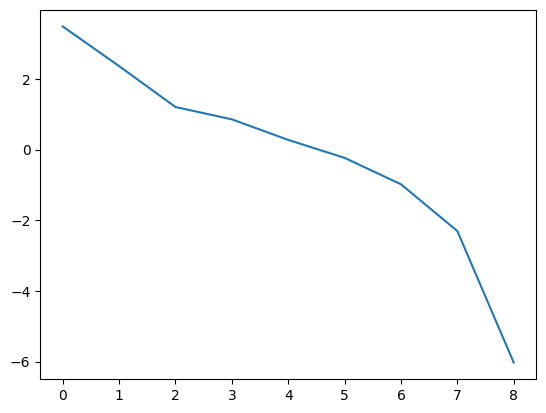

In [11]:
plt.plot(eta_fitted[:-1])

In [12]:
beta_fitted

array([[ 1.11448109, -0.53170753],
       [ 0.99066412, -0.51306623],
       [ 0.39871225, -0.37032834],
       [ 0.91611433, -0.46547815],
       [ 0.93091285, -0.45768833],
       [ 0.91048521, -0.44745564],
       [ 0.90108556, -0.44246244],
       [ 0.91714817, -0.45023248],
       [ 0.95614481, -0.46871021],
       [ 1.00549376, -0.49273023]])

In [195]:
next(omnimodel.parameters())

Parameter containing:
tensor([[ 0.9309, -0.4577]], requires_grad=True)

In [203]:
# Subpopulation simulation

set_random_seed(10)
# Simiulation config
sim_n_train = 1000
censor_rate = 0.001
sim_n_test = 10000

# Two subgroups
beta_major = np.array([1, 1])
beta_minor = np.array([1, 0.1])
G_dist = lambda n: binomial(1, 0.9, n)

# Grids
eps_candidates = np.linspace(0.05, 1.0, 5)
G_test_candidates = np.array([0,1])
avg_test_loss = np.zeros((len(eps_candidates), len(G_test_candidates)))
beta_fitted = np.zeros((len(eps_candidates), len(beta_major)))
eta_fitted = np.zeros(len(eps_candidates))

log_hr_linear = lambda X, beta: np.dot(X, beta)
# Simulation
# Train model
sim_X_train = normal(size=(sim_n_train, len(beta_major)))

#sim_G_train = G_dist(sim_n_train)
sim_G_train = np.ones(sim_n_train)

log_hr_train = sim_G_train*log_hr_linear(sim_X_train, beta_major) + (1-sim_G_train)*log_hr_linear(sim_X_train, beta_minor)
sim_failure_time_train, sim_censor_time_train, sim_event_train, sim_time_train = simulate_cox_dgp(log_hr=log_hr_train, sim_n=sim_n_train, censor_rate=censor_rate)

sim_X_test = normal(size=(sim_n_test, len(beta_major)))
for eps_ind, eps in enumerate(eps_candidates):
    model, eta_fitted[eps_ind] = fit_std_exp_baseline_dro_cox(sim_X_train, sim_event_train, sim_time_train, eps = eps, epochs=1000, lr=0.005)
    print(eps)
    with torch.no_grad():
        beta_fitted[eps_ind,:] = next(model.parameters()).numpy().reshape((-1,))
    for G_ind, G in enumerate(G_test_candidates):
        avg_test_loss[eps_ind, G_ind] = eval_test(beta_fitted=beta_fitted[eps_ind,:], beta_dgp=G*beta_major + (1 - G)*beta_minor, X_test=sim_X_test).mean()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_26532\2657678835.py:17: RuntimeWarning: divide by zero encountered in log
  def simulate_cox_dgp(log_hr, S_0_inv = lambda p: -np.log(p), sim_n=200, censor_rate = 0.4):


tensor(91.1194, grad_fn=<AddBackward0>)
tensor(89.4227, grad_fn=<AddBackward0>)
tensor(87.7622, grad_fn=<AddBackward0>)
tensor(86.1379, grad_fn=<AddBackward0>)
tensor(84.5497, grad_fn=<AddBackward0>)
tensor(82.9975, grad_fn=<AddBackward0>)
tensor(81.4814, grad_fn=<AddBackward0>)
tensor(80.0017, grad_fn=<AddBackward0>)
tensor(78.5591, grad_fn=<AddBackward0>)
tensor(77.1535, grad_fn=<AddBackward0>)
tensor(75.7849, grad_fn=<AddBackward0>)
tensor(74.4529, grad_fn=<AddBackward0>)
tensor(73.1554, grad_fn=<AddBackward0>)
tensor(71.8879, grad_fn=<AddBackward0>)
tensor(70.6496, grad_fn=<AddBackward0>)
tensor(69.4400, grad_fn=<AddBackward0>)
tensor(68.2584, grad_fn=<AddBackward0>)
tensor(67.1043, grad_fn=<AddBackward0>)
tensor(65.9772, grad_fn=<AddBackward0>)
tensor(64.8765, grad_fn=<AddBackward0>)
tensor(63.8017, grad_fn=<AddBackward0>)
tensor(62.7523, grad_fn=<AddBackward0>)
tensor(61.7278, grad_fn=<AddBackward0>)
tensor(60.7275, grad_fn=<AddBackward0>)
tensor(59.7510, grad_fn=<AddBackward0>)


In [186]:
eta_fitted

array([ 6.03663156e+00,  2.99147977e+00,  3.53764412e-01, -2.85746631e+00,
       -9.94676846e+02])

In [204]:
beta_fitted

array([[1.29139209, 1.17895269],
       [1.08728421, 1.22135198],
       [0.88414437, 1.01738846],
       [1.02235818, 1.03487837],
       [1.00599325, 1.01446819]])

In [ ]:
beta 

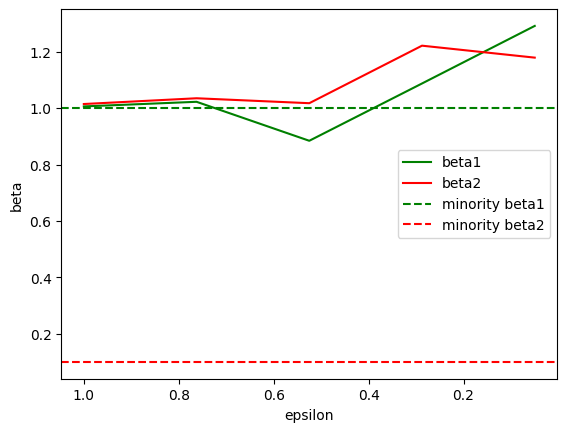

In [205]:
plt.plot(eps_candidates, beta_fitted[:,0], label = 'beta1', color = 'g')
plt.plot(eps_candidates, beta_fitted[:,1], label = 'beta2', color = 'r')
plt.axhline(y=beta_minor[0], color='g', linestyle='--', label='minority beta1')
plt.axhline(y=beta_minor[1], color='r', linestyle='--', label='minority beta2')
plt.xlabel('epsilon')
plt.ylabel('beta')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

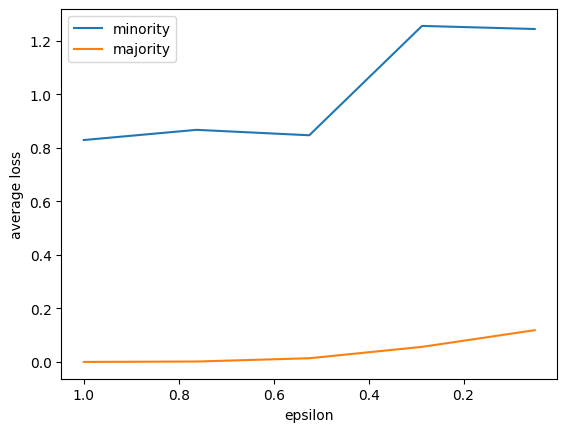

In [174]:
plt.plot(eps_candidates, avg_test_loss[:,0], label = 'minority')
plt.plot(eps_candidates, avg_test_loss[:,1], label = 'majority')
plt.xlabel('epsilon')
plt.ylabel('average loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

# Suppopulations

## No censoring

In [31]:
np.var(np.log(weibull(12.1, 1000000)))

0.011244492724967992

In [128]:
set_random_seed(11551)
# Simulation configs
def weibull_baseline_loss_indiv(pred, y, S0_shape, S0_scale=1): 
    return -y[0] * (pred + np.log(S0_shape) + (S0_shape - 1)*np.log(y[1]) - S0_shape*np.log(S0_scale)) + np.exp(pred)*(y[1]/S0_scale)**S0_shape
sq_error_loss_indiv = lambda pred, y: (y - pred)**2

sim_n_train = 1000
sim_n_test = 100000
censor_rate = 0.4
beta_major = np.array([1,1])
beta_minor = np.array([2,2])
minor_prop = 0.1
S0_shape = 12

# Data generation
sim_X_train = normal(size=(sim_n_train, len(beta_major)))
G_train = binomial(1, 1-minor_prop, sim_n_train)
log_hr_major_train = np.dot(sim_X_train, beta_major)
log_hr_minor_train = np.dot(sim_X_train, beta_minor)
log_hr_train = G_train*log_hr_major_train + (1-G_train)*log_hr_minor_train
sim_failure_time_train, sim_censor_time_train, sim_event_train, sim_time_train = simulate_weibull_failure_cox(log_hr_train, S0_shape=S0_shape, censor_rate=censor_rate)

sim_X_test = normal(size=(sim_n_test, len(beta_major)))
log_hr_major_test = np.dot(sim_X_test, beta_major)
log_hr_minor_test = np.dot(sim_X_test, beta_minor)
G_test = binomial(1, 1-minor_prop, sim_n_test)
log_hr_test = G_test*log_hr_major_test + (1-G_test)*log_hr_minor_test
sim_failure_time_major_test, sim_censor_time_major_test, sim_event_major_test, sim_time_major_test = simulate_weibull_failure_cox(log_hr_major_test, S0_shape=S0_shape, censor_rate=censor_rate)
sim_failure_time_minor_test, sim_censor_time_minor_test, sim_event_minor_test, sim_time_minor_test = simulate_weibull_failure_cox(log_hr_minor_test, S0_shape=S0_shape, censor_rate=censor_rate)
sim_failure_time_test, sim_censor_time_test, sim_event_test, sim_time_test = simulate_weibull_failure_cox(log_hr_test, S0_shape=S0_shape, censor_rate=censor_rate)

# Arrays for storing simulation results
eps_candidates = np.linspace(0.1, 1.0, 19)
G_test_candidates = np.array([0,1])
beta_fitted = np.zeros((len(eps_candidates), len(beta_major)))
eta_fitted = np.zeros((len(eps_candidates)))
dro_loss_fitted = np.zeros((len(eps_candidates)))
test_loss = np.zeros((len(eps_candidates), 2))

for eps_ind, eps in enumerate(eps_candidates):
    model_scipy = DroOptimizer(weibull_baseline_loss_indiv, eps = eps)
    model_scipy.fit_dro(sim_X_train, (sim_event_train, sim_time_train), verbose=False, S0_shape=S0_shape)
    beta_fitted[eps_ind,:] = model_scipy.beta
    eta_fitted[eps_ind] = model_scipy.eta
    dro_loss_fitted[eps_ind] = model_scipy.optimizer.fun
    # test_loss[eps_ind,0] = weibull_baseline_loss_indiv(np.dot(sim_X_test, beta_fitted[eps_ind,:]), (np.ones(sim_n_test), sim_failure_time_minor_test), S0_shape=S0_shape).mean()
    # test_loss[eps_ind,1] = weibull_baseline_loss_indiv(np.dot(sim_X_test, beta_fitted[eps_ind,:]), (np.ones(sim_n_test), sim_failure_time_major_test), S0_shape=S0_shape).mean()
    test_loss[eps_ind,0] = sq_error_loss_indiv(np.dot(sim_X_test, beta_fitted[eps_ind,:]), np.dot(sim_X_test, beta_minor)).mean()
    test_loss[eps_ind,1] = sq_error_loss_indiv(np.dot(sim_X_test, beta_fitted[eps_ind,:]), np.dot(sim_X_test, beta_major)).mean()
    print(f"-----{eps:.2f}-----")

-----0.10-----
-----0.15-----
-----0.20-----
-----0.25-----
-----0.30-----
-----0.35-----
-----0.40-----
-----0.45-----
-----0.50-----
-----0.55-----
-----0.60-----
-----0.65-----
-----0.70-----
-----0.75-----
-----0.80-----
-----0.85-----
-----0.90-----
-----0.95-----
-----1.00-----


In [ ]:
set_random_seed(11551)
# Simulation configs
def weibull_baseline_loss_indiv(pred, y, S0_shape, S0_scale=1): 
    return -y[0] * (pred + np.log(S0_shape) + (S0_shape - 1)*np.log(y[1]) - S0_shape*np.log(S0_scale)) + np.exp(pred)*(y[1]/S0_scale)**S0_shape
sq_error_loss_indiv = lambda pred, y: (y - pred)**2

sim_n_train = 1000
sim_n_test = 100000
censor_rate = 0.4
beta_major = np.array([1,1])
beta_minor = np.array([2,2])
minor_prop = 0.1
S0_shape = 12

# Data generation
sim_X_train = normal(size=(sim_n_train, len(beta_major)))
G_train = binomial(1, 1-minor_prop, sim_n_train)
log_hr_major_train = np.dot(sim_X_train, beta_major)
log_hr_minor_train = np.dot(sim_X_train, beta_minor)
log_hr_train = G_train*log_hr_major_train + (1-G_train)*log_hr_minor_train
sim_failure_time_train, sim_censor_time_train, sim_event_train, sim_time_train = simulate_weibull_failure_cox(log_hr_train, S0_shape=S0_shape, censor_rate=censor_rate)

sim_X_test = normal(size=(sim_n_test, len(beta_major)))
log_hr_major_test = np.dot(sim_X_test, beta_major)
log_hr_minor_test = np.dot(sim_X_test, beta_minor)
G_test = binomial(1, 1-minor_prop, sim_n_test)
log_hr_test = G_test*log_hr_major_test + (1-G_test)*log_hr_minor_test
sim_failure_time_major_test, sim_censor_time_major_test, sim_event_major_test, sim_time_major_test = simulate_weibull_failure_cox(log_hr_major_test, S0_shape=S0_shape, censor_rate=censor_rate)
sim_failure_time_minor_test, sim_censor_time_minor_test, sim_event_minor_test, sim_time_minor_test = simulate_weibull_failure_cox(log_hr_minor_test, S0_shape=S0_shape, censor_rate=censor_rate)
sim_failure_time_test, sim_censor_time_test, sim_event_test, sim_time_test = simulate_weibull_failure_cox(log_hr_test, S0_shape=S0_shape, censor_rate=censor_rate)

# Arrays for storing simulation results
eps_candidates = np.linspace(0.1, 1.0, 19)
G_test_candidates = np.array([0,1])
beta_fitted = np.zeros((len(eps_candidates), len(beta_major)))
eta_fitted = np.zeros((len(eps_candidates)))
dro_loss_fitted = np.zeros((len(eps_candidates)))
test_loss = np.zeros((len(eps_candidates), 2))

for eps_ind, eps in enumerate(eps_candidates):
    model_scipy = DroOptimizer(weibull_baseline_loss_indiv, eps = eps)
    model_scipy.fit_dro(sim_X_train, (sim_event_train, sim_time_train), verbose=False, S0_shape=S0_shape)
    beta_fitted[eps_ind,:] = model_scipy.beta
    eta_fitted[eps_ind] = model_scipy.eta
    dro_loss_fitted[eps_ind] = model_scipy.optimizer.fun
    # test_loss[eps_ind,0] = weibull_baseline_loss_indiv(np.dot(sim_X_test, beta_fitted[eps_ind,:]), (np.ones(sim_n_test), sim_failure_time_minor_test), S0_shape=S0_shape).mean()
    # test_loss[eps_ind,1] = weibull_baseline_loss_indiv(np.dot(sim_X_test, beta_fitted[eps_ind,:]), (np.ones(sim_n_test), sim_failure_time_major_test), S0_shape=S0_shape).mean()
    test_loss[eps_ind,0] = sq_error_loss_indiv(np.dot(sim_X_test, beta_fitted[eps_ind,:]), np.dot(sim_X_test, beta_minor)).mean()
    test_loss[eps_ind,1] = sq_error_loss_indiv(np.dot(sim_X_test, beta_fitted[eps_ind,:]), np.dot(sim_X_test, beta_major)).mean()
    print(f"-----{eps:.2f}-----")

In [129]:
sim_event_train.mean()

0.573

In [130]:
dro_loss_test = np.zeros((len(eps_candidates)))
for eps_ind, eps in enumerate(eps_candidates):
    model_scipy = DroOptimizer(weibull_baseline_loss_indiv, eps = eps)
    dro_loss_test[eps_ind] = model_scipy.dro_loss(beta_fitted[eps_ind,:], eta_fitted[eps_ind], sim_X_test, (sim_event_test, sim_time_test), S0_shape=S0_shape)

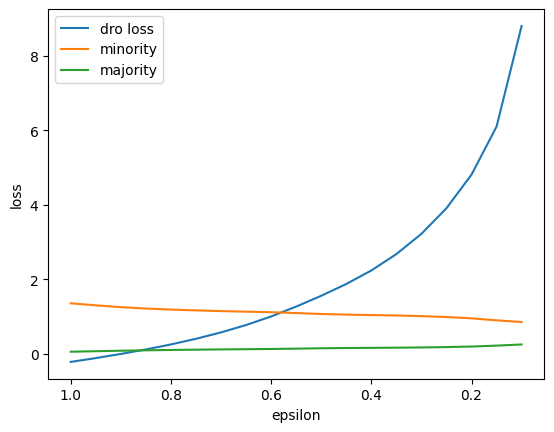

In [131]:
plt.plot(eps_candidates, dro_loss_test, label = 'dro loss')
plt.plot(eps_candidates, test_loss[:,0], label = 'minority')
plt.plot(eps_candidates, test_loss[:,1], label = 'majority')
plt.xlabel('epsilon')
plt.ylabel('loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

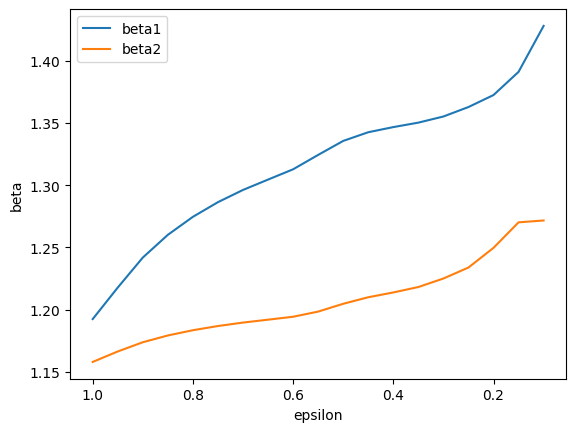

In [132]:
plt.plot(eps_candidates, beta_fitted[:,0], label = 'beta1')
plt.plot(eps_candidates, beta_fitted[:,1], label = 'beta2')
plt.xlabel('epsilon')
plt.ylabel('beta')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

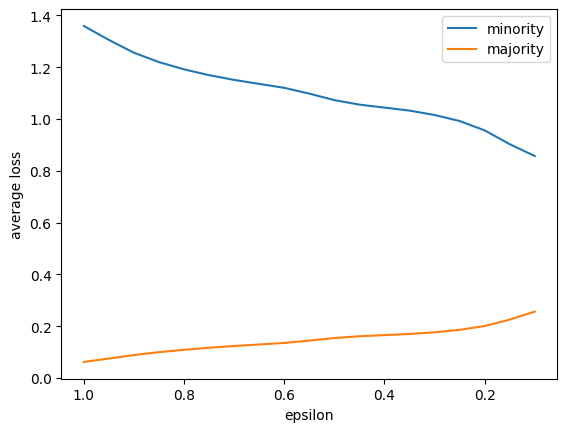

In [133]:
plt.plot(eps_candidates, test_loss[:,0], label = 'minority')
plt.plot(eps_candidates, test_loss[:,1], label = 'majority')
plt.xlabel('epsilon')
plt.ylabel('average loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

## Linear Regression

In [186]:
set_random_seed(0)
# Simulation configs
sim_n_train = 1000
sim_n_test = 100000
beta_major = np.array([1,1])
beta_minor = np.array([1, 0.1])
sq_error_loss_indiv = lambda pred, y: (y - pred)**2
minor_prop = 0.1
sigma = 0.1

# Data generation
sim_X_train = normal(size=(sim_n_train, len(beta_major)))
G_train = binomial(1, 1-minor_prop, sim_n_train)
loc_major_train = np.dot(sim_X_train, beta_major)
loc_minor_train = np.dot(sim_X_train, beta_minor)
loc_train = G_train*loc_major_train + (1-G_train)*loc_minor_train
sim_y_train = loc_train + normal(loc=0, scale=sigma)

sim_X_test = normal(size=(sim_n_test, len(beta_major)))
G_test = binomial(1, 1-minor_prop, sim_n_test)
sim_X_major_test = sim_X_test[G_test==1]
sim_X_minor_test = sim_X_test[G_test==0]
loc_major_test = np.dot(sim_X_test, beta_major)
loc_minor_test = np.dot(sim_X_test, beta_minor)
loc_test = G_test*loc_major_test + (1-G_test)*loc_minor_test
sim_y_test = loc_test + normal(loc=0, scale=sigma)
sim_y_major_test = loc_major_test[G_test==1] + normal(loc=0, scale=sigma)
sim_y_minor_test = loc_minor_test[G_test==0] + normal(loc=0, scale=sigma)

# Arrays for storing simulation results
eps_candidates = np.linspace(0.05, 1.0, 20)
# rho_candidates = np.exp(np.linspace(-2.0, 0.5, 20))
# eps_candidates = 1/(rho_candidates**0.5 + 1)
G_test_candidates = np.array([0,1])
beta_fitted = np.zeros((len(eps_candidates), len(beta_major)))
eta_fitted = np.zeros((len(eps_candidates)))
dro_loss_fitted = np.zeros((len(eps_candidates)))

dro_loss_test = np.zeros((len(eps_candidates)))
test_loss = np.zeros((len(eps_candidates), 2))

for eps_ind, eps in enumerate(eps_candidates):
    model_scipy = DroOptimizer(sq_error_loss_indiv, eps = eps)
    model_scipy.fit_dro(sim_X_train, sim_y_train, verbose=False)
    beta_fitted[eps_ind,:] = model_scipy.beta
    eta_fitted[eps_ind] = model_scipy.eta
    dro_loss_fitted[eps_ind] = model_scipy.optimizer.fun
    test_loss[eps_ind,0] = sq_error_loss_indiv(np.dot(sim_X_minor_test, beta_fitted[eps_ind,:]), sim_y_minor_test).mean()
    test_loss[eps_ind,1] = sq_error_loss_indiv(np.dot(sim_X_major_test, beta_fitted[eps_ind,:]), sim_y_major_test).mean()
    dro_loss_test[eps_ind] = model_scipy.dro_loss(beta_fitted[eps_ind,:], eta_fitted[eps_ind], sim_X_test, sim_y_test)
    print(f"-----{eps}-----")

-----0.05-----
-----0.1-----
-----0.15-----
-----0.2-----
-----0.25-----
-----0.3-----
-----0.35-----
-----0.39999999999999997-----
-----0.44999999999999996-----
-----0.49999999999999994-----
-----0.5499999999999999-----
-----0.6-----
-----0.65-----
-----0.7-----
-----0.75-----
-----0.7999999999999999-----
-----0.85-----
-----0.9-----
-----0.95-----
-----1.0-----


In [187]:
sim_X_test[G_test==1].shape

(90064, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


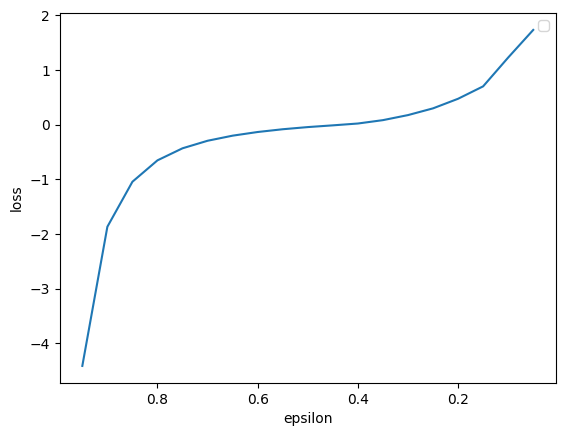

In [188]:
plt.plot(eps_candidates[:-1], eta_fitted[:-1])
plt.xlabel('epsilon')
plt.ylabel('loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

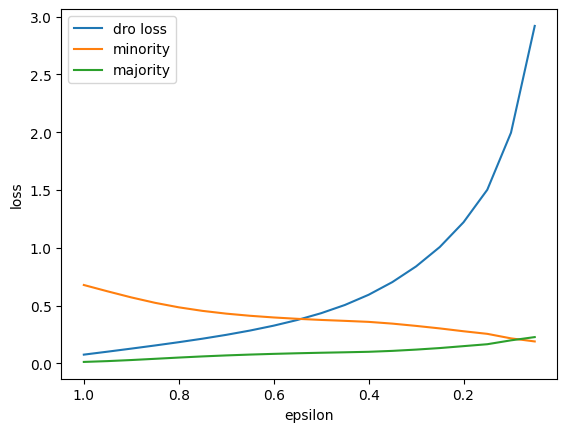

In [189]:
plt.plot(eps_candidates, dro_loss_test, label = 'dro loss')
plt.plot(eps_candidates, test_loss[:,0], label = 'minority')
plt.plot(eps_candidates, test_loss[:,1], label = 'majority')
plt.xlabel('epsilon')
plt.ylabel('loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

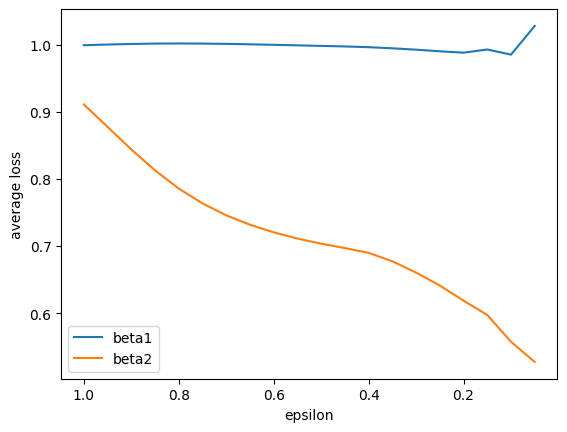

In [190]:
plt.plot(eps_candidates, beta_fitted[:,0], label = 'beta1')
plt.plot(eps_candidates, beta_fitted[:,1], label = 'beta2')
plt.xlabel('epsilon')
plt.ylabel('average loss')
plt.gca().invert_xaxis()
plt.legend()
plt.show()

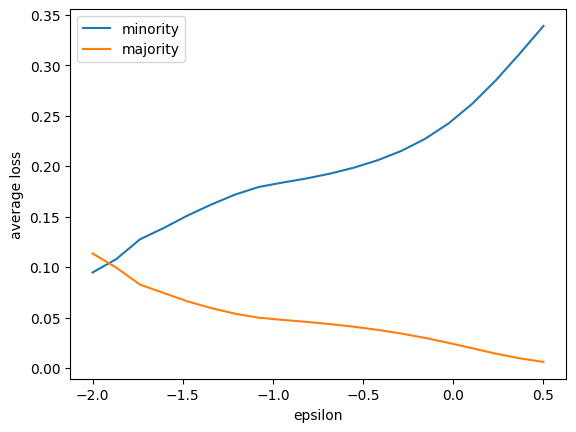

In [191]:
plt.plot(np.linspace(-2.0, 0.5, 20), test_loss[:,0]/2, label = 'minority')
plt.plot(np.linspace(-2.0, 0.5, 20), test_loss[:,1]/2, label = 'majority')
plt.xlabel('epsilon')
plt.ylabel('average loss')
plt.legend()
plt.show()

# Quantile Regression

In [183]:
check_func = lambda pred, y, tau: (y - pred)*(tau - (y <= pred))

array([2.02278380e-01, 1.12264638e+00, 4.86439164e-01, 7.34788286e-02,
       2.07499027e-01, 7.29336529e-01, 6.30372838e-02, 1.69036939e-01,
       1.00379356e-01, 4.24848094e-01, 3.29009073e-01, 3.68882735e-01,
       7.24983062e-01, 9.13921494e-02, 7.36879161e-01, 1.91281035e-01,
       9.88198459e-01, 8.03742601e-02, 6.03389700e-01, 1.48951600e-01,
       7.07809193e-01, 9.77587473e-01, 1.97039395e-02, 3.90944953e-01,
       1.04170365e-01, 1.95651025e-01, 5.88116316e-01, 2.16365711e-01,
       1.53435724e-01, 1.79170807e-01, 1.77576805e-01, 8.60941526e-01,
       1.98690693e-01, 2.33590903e-01, 4.79704536e-03, 6.66912310e-02,
       6.15213135e-01, 3.20407290e-02, 2.87225057e-01, 3.02824467e-02,
       4.52613019e-01, 7.65922068e-01, 9.50144364e-01, 8.77626423e-02,
       5.29425639e-01, 6.13422311e-01, 4.90519294e-01, 3.55486360e-01,
       8.95135023e-01, 2.03194457e-01, 6.71679755e-01, 4.86898130e-01,
       9.74010368e-01, 3.51729650e-02, 7.42457171e-01, 4.55222105e-01,
      